In [169]:
import pandas as pd

df_bb = pd.read_csv('./data/imdb_barbie_Uncleaned.csv', header=None)
df_op = pd.read_csv('./data/imdb_oppenhimmer_Uncleaned.csv', header=None)
df_bb.drop_duplicates(inplace=True)
df_op.drop_duplicates(inplace=True)


# Regular Expression

In [170]:
import re

score_Reg = '(\d{1,2})\/\d{1,2}\s.*\s'
title_Reg = '\d{1,2}\/\d{1,2}\s(.*)'
people_found_helpful_Reg = '([\d,]*) out of ([\d,]*) found this helpful'
username_Reg = '\d{1,2}\/\d{1,2}\s.*\s([A-Za-z0-9_-]+)\d{2}\s(?:January|February|March|April|June|July|August|September|October|November|December)'
date_Reg = '(\d{1,2}\s(?:January|February|March|April|June|July|August|September|October|November|December)\s\d{4})'
review_Reg = '\d{1,2}\s\w+\s\d{4}\s([\s\S]*)\s[\d,]* out of [\d,]* found this helpful'

In [171]:
# Regular Expression test code

test_text = df_bb.iloc[0][0]

# print(test_text)

res = re.findall(score_Reg, test_text)
print(res)

res = re.findall(title_Reg, test_text)
print(res)

res = re.findall(username_Reg, test_text)
print(res)

res = re.findall(date_Reg, test_text)
print(res)

res = re.findall(people_found_helpful_Reg, test_text)
print(res)
print(int(res[0][0].replace(',', '')))
print(int(res[0][1].replace(',', '')))

res = re.findall(review_Reg, test_text)
print(res)

['6']
['Creative but preachy and confusing']
['Imshortok06']
['23 July 2023']
[('1,007', '1,363')]
1007
1363
['I\'m just going to get straight to the point: I liked some aspects of this movie and disliked other parts. Cinematography: awesome. Choreographed musical numbers: hilarious. Comedy: good. Margot Robbie: great. Ryan Gosling: awesome, and arguably the best part of the movie. The scenery and props really did help create the world. The storyline started off very intriguing. However, when the movie got to the meat of the plot and the central conflict, its message became confusing. It\'s like they wanted to make Ken the bad guy yet also sympathetic, which is not impossible or unheard of, but the way the writers did this was ineffective. Also, the resolution didn\'t make sense based on the message and events that led up to it. Lastly, I really hate it when movies try to empower women by dumbing down the men. I get that in a Barbie world, Ken is an afterthought, but in the real world 

# Cleaning Data

In [172]:
# Clean every row in data set

def get_cleaned_df(dirty_df):
	# cleaned_df = pd.DataFrame(columns=['score', 'title', 'username', 'date', 'people_found_helpful', 'review'])
	cleaned_df = pd.DataFrame(columns=['score', 'title', 'username', 'date', 'people_found_helpful', 'total_people_viewed', 'review'])
	
	for index in range(len(dirty_df)):
		row = dirty_df.iloc[index][0]
		
		score = re.findall(score_Reg, row)
		title = re.findall(title_Reg, row)
		username = re.findall(username_Reg, row)
		date = re.findall(date_Reg, row)
		people_found_helpful = re.findall(people_found_helpful_Reg, row)
		review = re.findall(review_Reg, row)
		
		if not score:
			score = 'NULL'
			continue
		else:
			score = int(score[0])
		if not title:
			title = ['NULL']
		if not username:
			username = ['NULL']
		if not date:
			date = ['NULL']
		if not people_found_helpful:
			people_found_helpful = 'NULL'
			total_people_viewed = 'NULL'
		else:
			total_people_viewed = int(people_found_helpful[0][1].replace(',', ''))
			people_found_helpful = int(people_found_helpful[0][0].replace(',', ''))
		if not review:
			review = ['NULL']
			
		cleaned_df.loc[index] = [score, title[0], username[0], date[0], people_found_helpful, total_people_viewed, review[0]]
	return cleaned_df


In [173]:
cleand_df_bb = get_cleaned_df(df_bb)
cleand_df_bb.drop_duplicates(subset=['username'], inplace=True)

In [174]:
cleand_df_bb

,score,title,username,date,people_found_helpful,total_people_viewed,review
0,6,Creative but preachy and confusing,Imshortok06,23 July 2023,1007,1363,I'm just going to get straight to the point: I...
1,6,"Beautiful film, but so preachy",LoveofLegacy,21 July 2023,1190,1646,"Margot does the best with what she's given, bu..."
2,6,Clever and fun beginning turns into another le...,Binkconn,21 July 2023,804,1173,"Barbie begins in an irresistible way, as a fun..."
3,8,It was depressing,coxaneesa,24 July 2023,152,242,Warning: Spoilers
4,9,A Technicolor Dream,heatherhilgers,24 July 2023,20,26,"Wow, this movie was a love letter to cinema. F..."
...,...,...,...,...,...,...,...
792,2,Barbie-not good,thongman,22 July 2023,5,17,The only reason this movie even gets a 2 from ...
793,5,Feminism but the rest?,iyaseminkose,23 July 2023,1,6,"I'm NOT a Barbie girl in NOT the Barbie World,..."
794,3,"Great sets, great execution but horrible story...",DaHermitKid,28 July 2023,1,5,"Firstly, the technical execution is top notch...."
795,2,Just meh.,apriljosey-29034,27 July 2023,0,1,Warning: Spoilers


In [175]:
cleand_df_op = get_cleaned_df(df_op)
cleand_df_op.drop_duplicates(subset=['username'], inplace=True)

In [176]:
cleand_df_op

,score,title,username,date,people_found_helpful,total_people_viewed,review
0,9,Murphy is exceptional,Orlando_Gardner,19 July 2023,1413,1597,You'll have to have your wits about you and yo...
1,8,"A challenging watch to be sure, but a worthwhi...",Jeremy_Urquhart,20 July 2023,685,819,One of the most anticipated films of the year ...
2,10,A brilliantly layered examination of a man thr...,MrDHWong,20 July 2023,556,691,"""Oppenheimer"" is a biographical thriller film ..."
3,10,Nolan delivers a powerfull biopic that shows t...,and_mikkelsen,20 July 2023,358,457,This movie is just... wow! I don't think I hav...
4,10,A Masterpiece,mohameddawoud-26019,19 July 2023,670,833,I may consider myself lucky to be alive to wat...
...,...,...,...,...,...,...,...
2031,7,"Huge story, but production fails sometimes",andreverschoor,27 July 2023,1,3,"Loved the movie, loved the actors efforts. Aft..."
2032,6,Tweaked,fmacr,25 July 2023,1,7,"I suppose these reviews are tweaked, otherwise..."
2033,6,Just a 6 for a near perfect film.,m-nicolaou-86-661254,24 July 2023,0,1,Ok let me start by the obvious ratings which w...
2034,6,No need to be 3 hours,scottahaynie,24 July 2023,0,0,Acting was tremendous and the true story behin...


# Graphing for Exploration

In [177]:
# combine the two data sets

cleand_df_bb['isBarbie'] = 1
cleand_df_op['isBarbie'] = 0

df = pd.concat([cleand_df_bb, cleand_df_op], ignore_index=True)

In [178]:
df

,score,title,username,date,people_found_helpful,total_people_viewed,review,isBarbie
0,6,Creative but preachy and confusing,Imshortok06,23 July 2023,1007,1363,I'm just going to get straight to the point: I...,1
1,6,"Beautiful film, but so preachy",LoveofLegacy,21 July 2023,1190,1646,"Margot does the best with what she's given, bu...",1
2,6,Clever and fun beginning turns into another le...,Binkconn,21 July 2023,804,1173,"Barbie begins in an irresistible way, as a fun...",1
3,8,It was depressing,coxaneesa,24 July 2023,152,242,Warning: Spoilers,1
4,9,A Technicolor Dream,heatherhilgers,24 July 2023,20,26,"Wow, this movie was a love letter to cinema. F...",1
...,...,...,...,...,...,...,...,...
2792,7,"Huge story, but production fails sometimes",andreverschoor,27 July 2023,1,3,"Loved the movie, loved the actors efforts. Aft...",0
2793,6,Tweaked,fmacr,25 July 2023,1,7,"I suppose these reviews are tweaked, otherwise...",0
2794,6,Just a 6 for a near perfect film.,m-nicolaou-86-661254,24 July 2023,0,1,Ok let me start by the obvious ratings which w...,0
2795,6,No need to be 3 hours,scottahaynie,24 July 2023,0,0,Acting was tremendous and the true story behin...,0


In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [180]:
# Creating graphable data

# numeric_df = pd.DataFrame(columns=['isBarbie', 'score', 'people_found_helpful', 'total_people_viewed', 'helpful_ratio', 'date', 'date_from_release','length_of_title', 'length_of_username', 'length_of_review'])
numeric_df = pd.DataFrame(columns=['isBarbie', 'score', 'date', 'people_found_helpful', 'total_people_viewed', 'helpful_ratio','length_of_title', 'length_of_username', 'length_of_review'])


numeric_df['isBarbie'] = df['isBarbie']
numeric_df['score'] = df['score']
numeric_df['date'] = df['date']
numeric_df['total_people_viewed'] = df['total_people_viewed']
numeric_df['people_found_helpful'] = df['people_found_helpful']
numeric_df['helpful_ratio'] = df['people_found_helpful'] / df['total_people_viewed']
numeric_df['length_of_title'] = df['title'].apply(lambda x: len(x))
numeric_df['length_of_username'] = df['username'].apply(lambda x: len(x))
numeric_df['length_of_review'] = df['review'].apply(lambda x: len(x))

numeric_df = numeric_df[~numeric_df['date'].str.contains('IMAX')]
numeric_df['date'] = pd.to_datetime(df['date'], format='%d %B %Y')
numeric_df['date_from_release'] = (numeric_df['date'] - pd.to_datetime('2023-07-23', format='%Y-%m-%d')).dt.days

In [181]:
numeric_df

,isBarbie,score,date,people_found_helpful,total_people_viewed,helpful_ratio,length_of_title,length_of_username,length_of_review,date_from_release
0,1,6,2023-07-23,1007,1363,0.738811,34,11,1216,0
1,1,6,2023-07-21,1190,1646,0.722965,30,12,786,-2
2,1,6,2023-07-21,804,1173,0.685422,69,8,601,-2
3,1,8,2023-07-24,152,242,0.628099,17,9,17,1
4,1,9,2023-07-24,20,26,0.769231,19,14,1239,1
...,...,...,...,...,...,...,...,...,...,...
2792,0,7,2023-07-27,1,3,0.333333,42,14,624,4
2793,0,6,2023-07-25,1,7,0.142857,7,5,1152,2
2794,0,6,2023-07-24,0,1,0.000000,33,20,1369,1
2795,0,6,2023-07-24,0,0,NaN,21,12,609,1


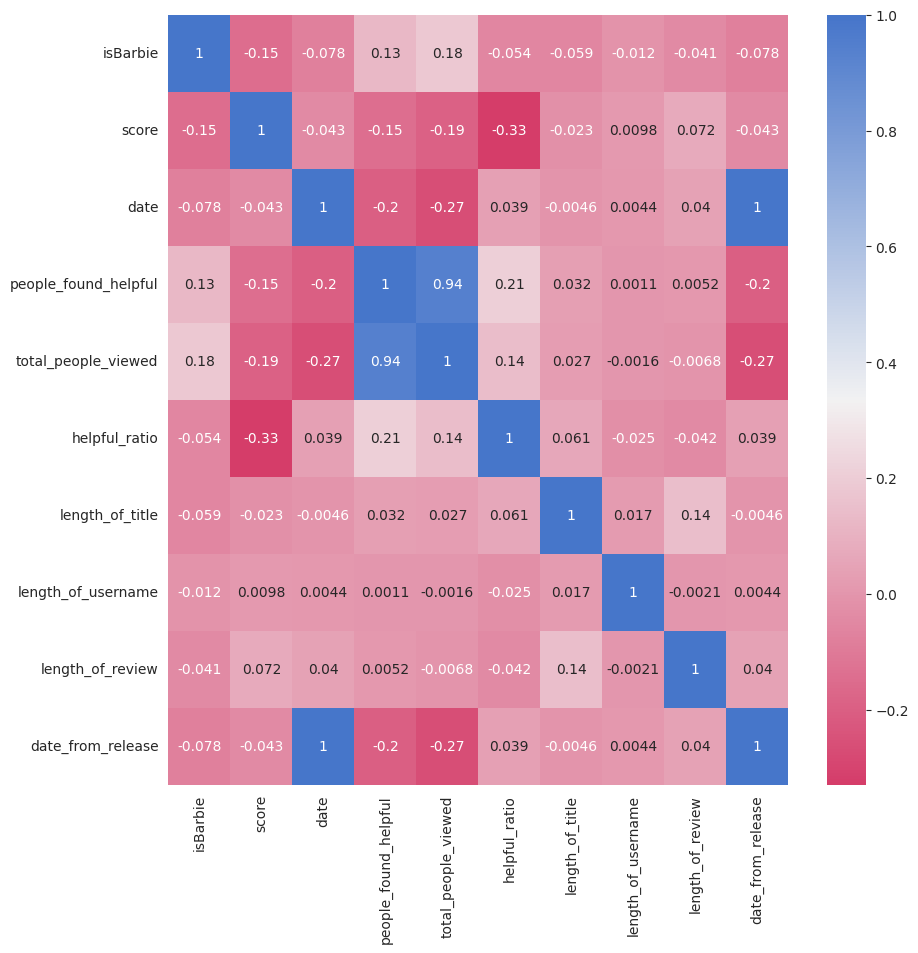

In [182]:
# Coorelation Matrix

drop_na_df = numeric_df[numeric_df['score'] != 'NULL']

fig1 = plt.figure(figsize=(10, 10))
ax1 = fig1.add_subplot(111)

cmap = sns.diverging_palette(0, 255, n=256, as_cmap=True)

sns.heatmap(data=drop_na_df.corr(), ax=ax1, cmap=cmap, annot=True)

plt.show()

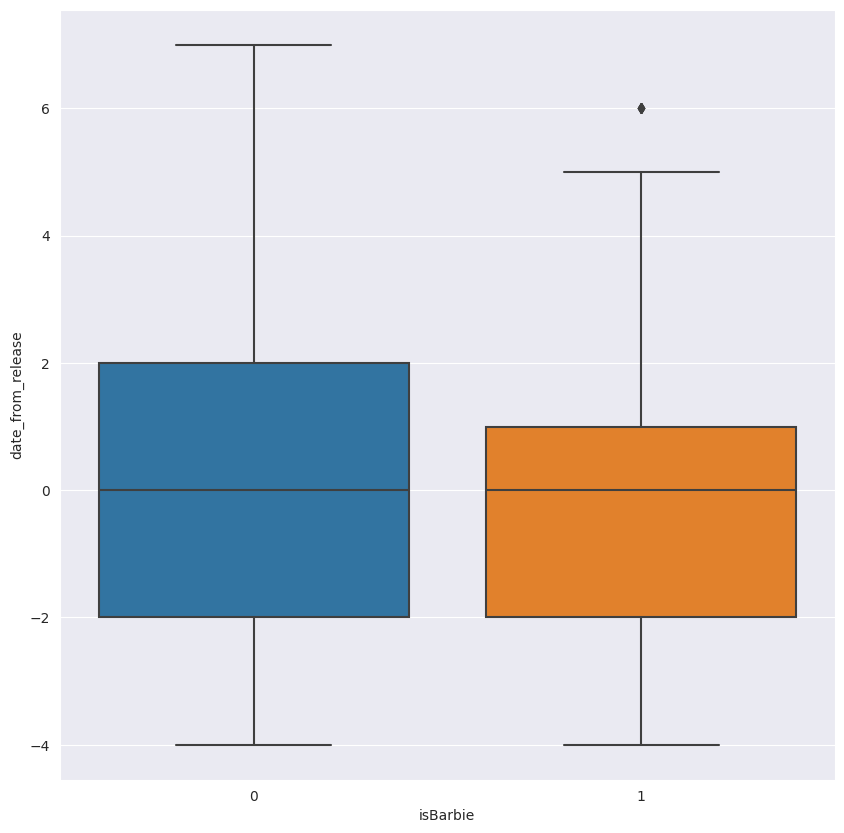

In [183]:
fig2 = plt.figure(figsize=(10, 10))
ax2 = fig2.add_subplot(111)

sns.boxplot(data=numeric_df, x='isBarbie', y='date_from_release', ax=ax2)

plt.show()

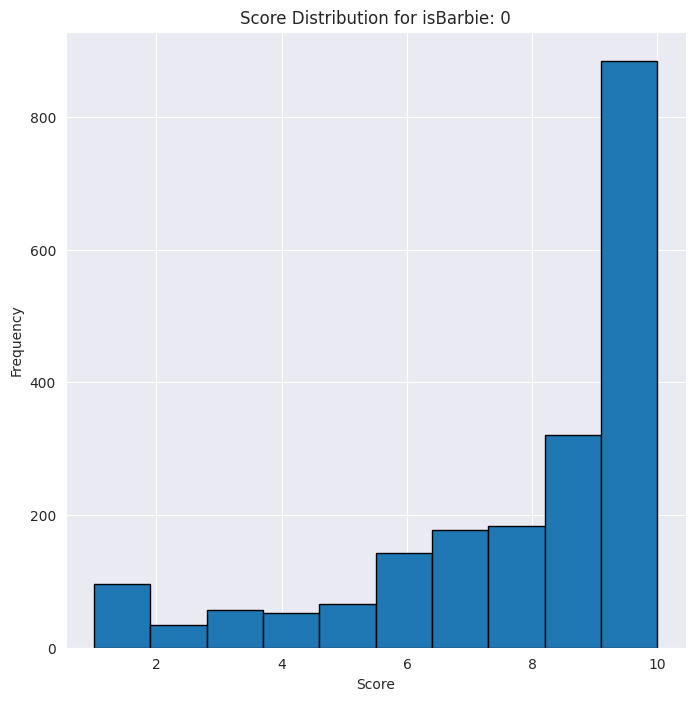

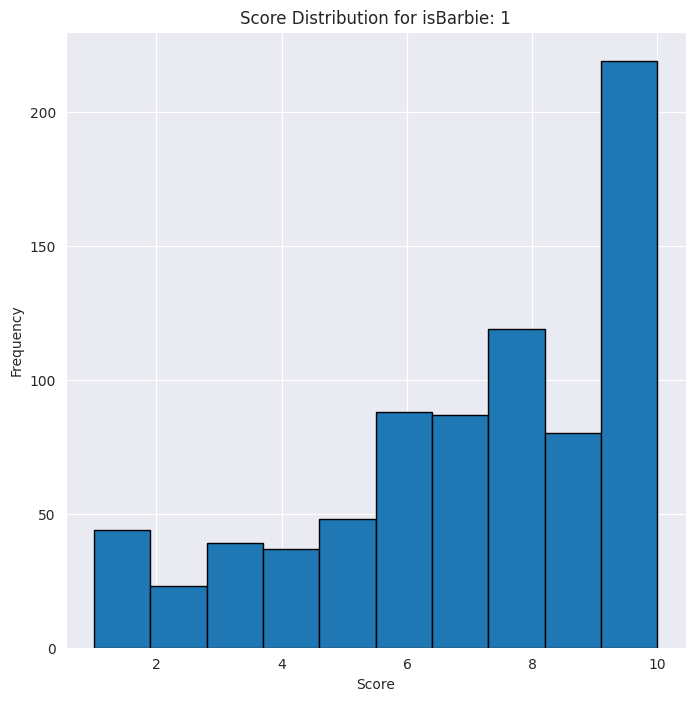

In [184]:
group_by = df.groupby('isBarbie')
for isBarbie, group_data in group_by:
    plt.figure(figsize=(8, 8))
    plt.hist(group_data['score'], edgecolor='black')
    plt.title(f'Score Distribution for isBarbie: {isBarbie}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

In [185]:
import nltk
from nltk.tokenize import word_tokenize

reviews = df.review.str.cat(sep=' ')

tokens = word_tokenize(reviews)

vocabulary = set(tokens)
print(len(vocabulary))

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/yuxin/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************
